In [1]:
import pickle as p
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm

In [2]:
df = p.load(open('total.p','rb'))
likert = pd.read_csv('likert.csv', header = None).T
likert = likert.set_index(np.arange(11,45)).drop(25)

In [3]:
all_subjects = np.concatenate((np.arange(11,25),np.arange(26,45)))

In [138]:
# Book-keeping Functions

def num_to_epoch(epoch_number):
    if epoch_number == 0:
        return 'UP1'
    elif epoch_number == 1:
        return 'UP2'
    elif epoch_number == 2:
        return 'P1'
    elif epoch_number == 3:
        return 'P2'
    elif epoch_number == 4:
        return 'REC'
    else:
        raise Exception('Invalid Epoch Number')

def num_to_subject(subject_number):
    return 'Subject'+str(subject_number)

def get_signal(measure, epoch, subjno):
    if isinstance(epoch,str):
        return df.loc[measure, epoch][num_to_subject(subjno)][:,0]
    elif isinstance(epoch, int):
        return df.loc[measure, num_to_epoch(epoch)][num_to_subject(subjno)][:,0]

def get_split_signal(measure, epoch, subjno,splitno):
    if isinstance(epoch,str):
        return df.loc[measure, epoch][num_to_subject(subjno)][:,0]
    elif isinstance(epoch, int):
        return df.loc[measure, num_to_epoch(epoch)][num_to_subject(subjno)][:,0]
    
def full_signal(measure, subjno):
    return np.concatenate((
        df.loc[measure, num_to_epoch(0)][num_to_subject(subjno)][:,0],
        df.loc[measure, num_to_epoch(1)][num_to_subject(subjno)][:,0],
        df.loc[measure, num_to_epoch(2)][num_to_subject(subjno)][:,0],
        df.loc[measure, num_to_epoch(3)][num_to_subject(subjno)][:,0],
        df.loc[measure, num_to_epoch(4)][num_to_subject(subjno)][:,0],
    ))

def is_perturbed(epoch):
    if epoch == 0 or epoch == 1 or epoch == 4:
        return 0
    elif epoch == 2 or epoch == 3:
        return 1
    
def scaled_correlation_time(signal1, signal2):
    signal1 = (signal1 - np.mean(signal1))/np.std(signal1)
    signal2 = (signal2 - np.mean(signal2))/np.std(signal2)
    acorr = np.correlate(signal1, signal2, mode='full')
    acorr = acorr[(acorr.size // 2 ):] / np.max(acorr)
#     plt.plot(acorr)
    tau = np.argmax([acorr < 1/np.exp(1)])
    return tau / len(acorr)

def correlation_integral(signal1, signal2):
    signal1 = (signal1 - np.mean(signal1))/np.std(signal1)
    signal2 = (signal2 - np.mean(signal2))/np.std(signal2)
    acorr = np.correlate(signal1, signal2, mode='full')
    acorr = acorr[(acorr.size // 2 ):] / np.max(acorr)
#     plt.plot(acorr)
    integral = np.trapz(acorr)
    return integral

def plot_full_experiment(measure, subjno):
    s1 = df.loc[measure, num_to_epoch(0)][num_to_subject(subjno)][:,0]
    s2 = df.loc[measure, num_to_epoch(1)][num_to_subject(subjno)][:,0]
    s3 = df.loc[measure, num_to_epoch(2)][num_to_subject(subjno)][:,0]
    s4 = df.loc[measure, num_to_epoch(3)][num_to_subject(subjno)][:,0]
    s5 = df.loc[measure, num_to_epoch(4)][num_to_subject(subjno)][:,0]
    fullsignal = np.concatenate((s1,s2,s3,s4,s5))
    plt.plot(fullsignal,'k',label = measure)
    plt.axvline(x = len(s1), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2)+len(s3), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2)+len(s3)+len(s4), color = 'k', linestyle = '--')
    plt.legend()

In [139]:
x = np.linspace(0,12,100)

stats.linregress(x,x).slope

1.0

In [140]:
# Signal Statistics

def signal_statistics(signal):
    mean = np.mean(signal)
    std = np.std(signal)
    skewness = stats.skew(signal)
    kurtosis = stats.kurtosis(signal)
    maximum = np.max(signal)
    minimum = np.min(signal)
    iqr = stats.iqr(signal)
    variation = stats.variation(signal)
    entropy = stats.entropy(np.abs(signal))
    corrtime = scaled_correlation_time(signal,signal)
    corrint = correlation_integral(signal,signal)
    
    
    slope = stats.linregress(np.arange(0,len(signal)), signal).slope
    
    
    return np.asarray([mean, std, skewness, kurtosis, maximum, minimum, iqr, variation, entropy, corrtime, slope, corrint])

In [234]:
hrfeatures = [];
tempfeatures = [];
edafeatures = [];

allfeatures = [];

targets = [];

for subjno in tqdm(all_subjects):
    
    for epoch in range(4):
        hr_signal = get_signal('HR',epoch,subjno)
        hrfeature = signal_statistics(hr_signal)
        hrfeatures.append(hrfeature)
        
        temp_signal = get_signal('TEMP',epoch,subjno)
        tempfeature = signal_statistics(temp_signal)
        tempfeatures.append(tempfeature)
        
        eda_signal = get_signal('EDA',epoch,subjno)
        edafeature = signal_statistics(eda_signal)
        edafeatures.append(edafeature)
        
        ## add cross-features
        
        xcorr_hr_temp = scaled_correlation_time(hr_signal,temp_signal)
        xcorr_hr_eda = scaled_correlation_time(hr_signal,eda_signal)
        xcorr_temp_eda = scaled_correlation_time(temp_signal,eda_signal)
        
#         xcorr_feature = np.asarray([xcorr_hr_temp,xcorr_hr_eda,xcorr_temp_eda])
#         lik = likert.loc[subjno][epoch]
#         binarized = (lik > np.median(likert)).astype(int)
#         targets.append(binarized)
        targets.append(is_perturbed(epoch))
        
        allfeature = np.concatenate((hrfeature, tempfeature, edafeature, xcorr_feature))
        allfeatures.append(allfeature)
        
        allfeature_names = ['hr_mean', 'hr_std', 'hr_skewness', 'hr_kurtosis', 'hr_maximum', 'hr_minimum', \
                            'hr_iqr', 'hr_variation', 'hr_entropy', 'hr_corrtime','hr_slope','hr_corrint',\
                            'temp_mean', 'temp_std', 'temp_skewness', 'temp_kurtosis', \
                            'temp_maximum', 'temp_minimum', 'temp_iqr', 'temp_variation', 'temp_entropy','temp_corrtime','temp_slope','temp_corrint',\
                            'eda_mean', 'eda_std', 'eda_skewness', 'eda_kurtosis', \
                            'eda_maximum', 'eda_minimum', 'eda_iqr', 'eda_variation', 'eda_entropy', 'eda_corrtime','eda_slope','eda_corrint',\
                           'xcorr_hr_temp','xcorr_hr_eda','xcorr_temp_eda']
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

100%|██████████| 33/33 [00:09<00:00,  3.48it/s]


# PCA

(array([66.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 66.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

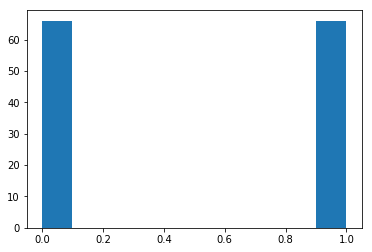

In [212]:
plt.hist(targets)

In [213]:
from sklearn.feature_selection import f_classif,mutual_info_classif

In [214]:
fscores = f_classif(fdf,targets)[0]

/Users/vedantchandra/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [36 37] are constant.
  UserWarning)
/Users/vedantchandra/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Text(0.5, 1.0, 'F-Score Feature Selection')

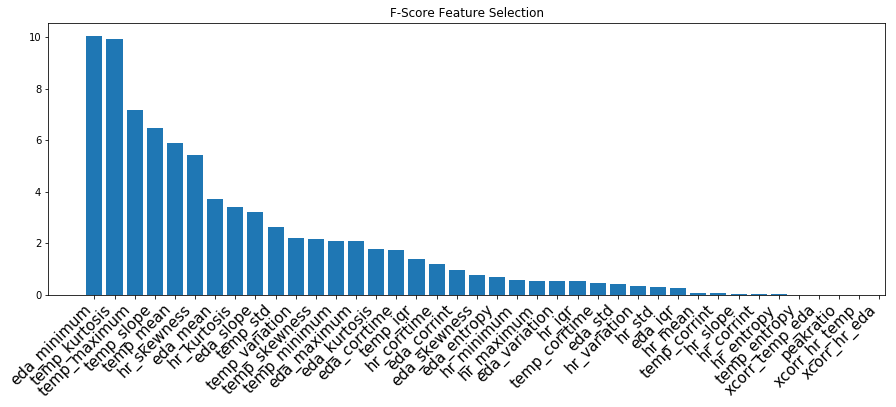

In [215]:
plt.figure(figsize=(15,5))
sortidx = np.argsort(-fscores)
plt.bar(fdf.columns[sortidx],height=fscores[sortidx],)
plt.xticks(rotation=45, ha='right',fontsize=15);
plt.title('F-Score Feature Selection')

In [216]:
scores = mutual_info_classif(fdf,targets)

Text(0.5, 1.0, 'Mutual Information Feature Selection')

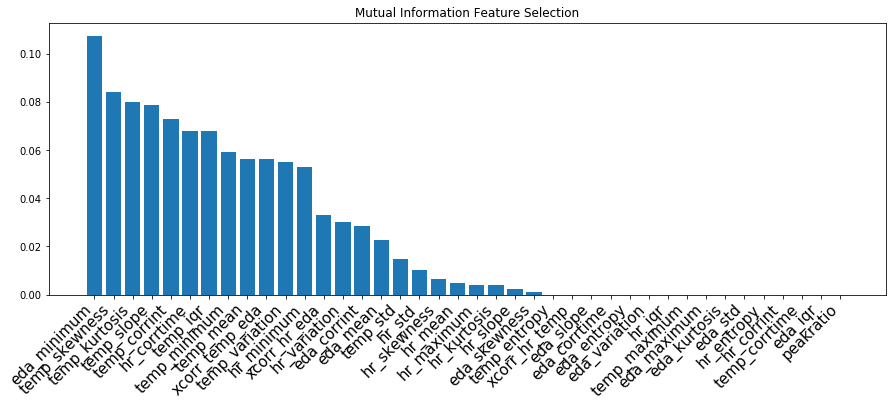

In [217]:
plt.figure(figsize=(15,5))
sortidx = np.argsort(-scores)
plt.bar(fdf.columns[sortidx],height=scores[sortidx],)
plt.xticks(rotation=45, ha='right',fontsize=15);
plt.title('Mutual Information Feature Selection')

In [218]:
allfeatures = fdf[fdf.columns[sortidx][0:10]]

In [219]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC,SVR
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import train_test_split, LeaveOneOut

In [220]:
X = np.asarray(allfeatures)
t = np.asarray(targets)
encoder = preprocessing.OneHotEncoder(categories = 'auto')
t_onehot = encoder.fit_transform(t.reshape(-1,1)).toarray()

sc = preprocessing.MinMaxScaler()
X_scaled = sc.fit_transform(X)

In [221]:
clf = LogisticRegression(solver = 'lbfgs', max_iter = 1000000, tol = 0.000001)

In [222]:
clf.fit(X,t)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=1e-06, verbose=0,
                   warm_start=False)

In [223]:
clf.score(X,t)

0.7196969696969697

## Support Vector Machine

In [224]:
X = np.asarray(allfeatures)
t = np.asarray(targets)

sc = preprocessing.StandardScaler()
X_scaled = sc.fit_transform(X)

In [229]:
loo = LeaveOneOut()
preds = [];
for train_idx,test_idx in tqdm(loo.split(X)):
    X_train,y_train = X_scaled[train_idx],t[train_idx]
    X_test,y_test = X_scaled[test_idx],t[test_idx]
    svc = SVC(gamma = 0.01, C = 800,tol = 0.01, kernel = 'rbf')
    svc.fit(X_train,y_train)
    preds.append(svc.predict(X_test)[0])

132it [00:00, 375.74it/s]


In [230]:
np.mean(preds == t)

0.7045454545454546

## Random Forest

In [231]:
X = np.asarray(allfeatures)
t = np.asarray(targets)

In [228]:
loo = LeaveOneOut()
preds = [];
for train_idx,test_idx in tqdm(loo.split(X)):
    X_train,y_train = X[train_idx],t[train_idx]
    X_test,y_test = X[test_idx],t[test_idx]
    rf = RandomForestClassifier(n_estimators = 100)
    rf.fit(X_train,y_train)
    preds.append(rf.predict(X_test)[0])

132it [00:10, 13.72it/s]


In [232]:
accuracy = np.mean((preds - t) == 0)
print('LOO Accuracy: %.2f percent'%(accuracy*100))

LOO Accuracy: 70.45 percent


In [233]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = allfeature_names,
                                    columns=['importance']).sort_values('importance', ascending=False)

ValueError: Shape of passed values is (10, 1), indices imply (40, 1)

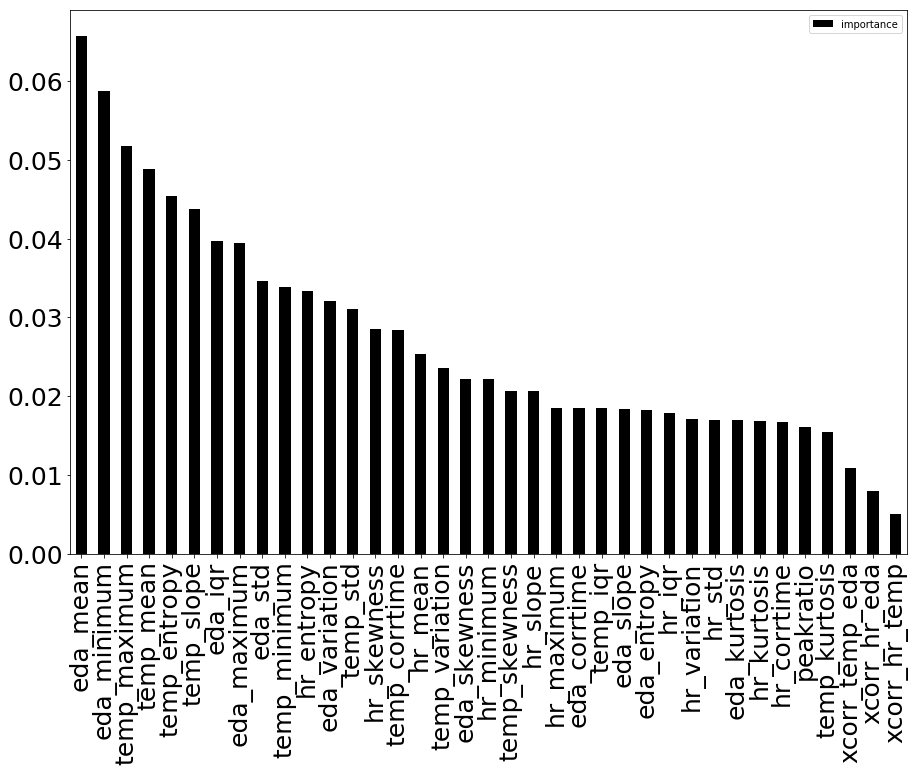

In [82]:
feature_importances.plot(kind = 'bar', figsize = (15,10), color = 'k', fontsize = 25)

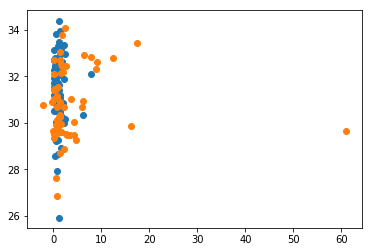

In [118]:
targets = np.asarray(targets)

plt.scatter(fdf['eda_mean'][targets == 0], fdf['temp_minimum'][targets == 0])
plt.scatter(fdf['eda_mean'][targets == 1], fdf['temp_minimum'][targets == 1])